# Image Prediction
We want to be able to perform predictions on arbitrary image sizes, but the network has specifically been trained to process 512x512 images. Passing larger images takes up a lot of memory, so I thought that one way to get around that would be to chop up the image into 512x512 pieces, after which each piece is passed through the network and merged together afterwards. The end result is a method that works on arbitrary image sizes. This notebook is primarily for testing that this functionality works as intended.

In [1]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from libs.pconv_model import PConvUnet
from libs.util import random_mask

%load_ext autoreload
%autoreload 2

# SETTINGS
SAMPLE_IMAGE = 'data/my_bike.jpg'
BATCH_SIZE = 4

Using TensorFlow backend.


# Sample Images
These are the images and masks that we will attempt to pass through the network; they are all either too small or too large in one dimension.

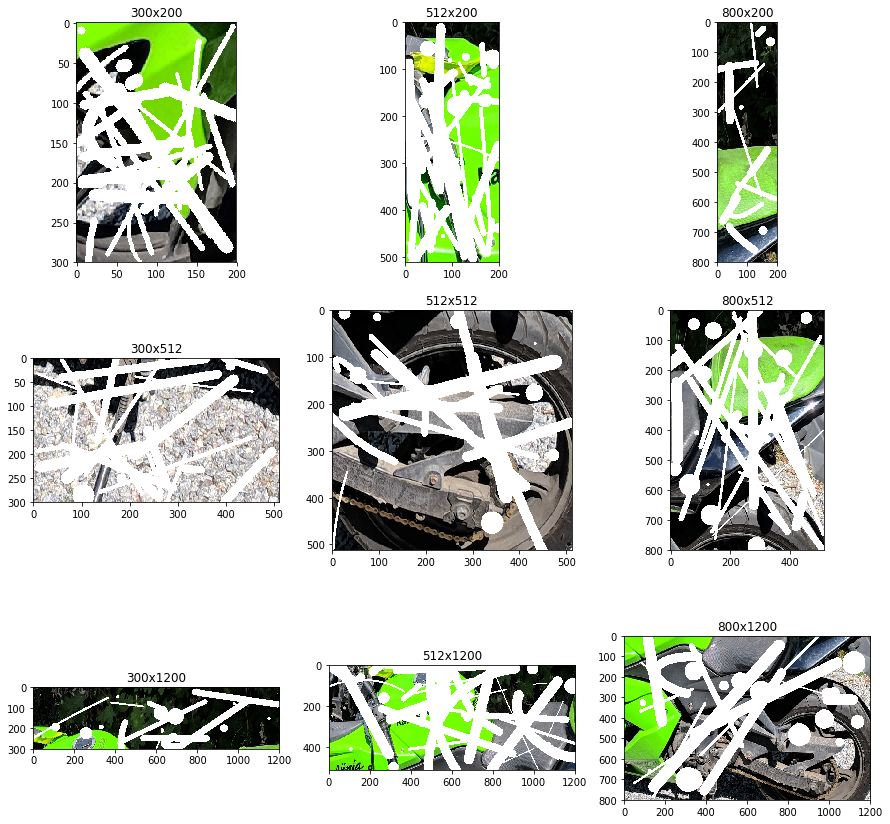

In [2]:
# Image samplings
crops = [
    [300, 200], [512, 200], [800, 200],
    [300, 512], [512, 512], [800, 512],
    [300, 1200], [512, 1200], [800, 1200],
]

# Setup the figure
_, axes = plt.subplots(3, 3, figsize=(15, 15))

# Set random seed
np.random.seed(7)

# Lists for saving images and masks
imgs, masks = [], []

# Plot images
for crop, ax in zip(crops, axes.flatten()):
    
    # Load image
    im = Image.open(SAMPLE_IMAGE).resize((2048, 2048))
    
    # Crop image
    h, w = im.height, im.width
    left = np.random.randint(0, w - crop[1])
    right = left + crop[1]
    upper = np.random.randint(0, h - crop[0])
    lower = upper + crop[0]
    im = im.crop((left, upper, right, lower))

    # Create masked array
    im = np.array(im) / 255
    mask = random_mask(*crop)
    im[mask==0] = 1
    
    # Store for prediction
    imgs.append(im)
    masks.append(mask)

    # Show image
    ax.imshow(im)
    ax.set_title("{}x{}".format(crop[0], crop[1]))

# Model Loading
We'll load the model trained on ImageNet

In [3]:
model = PConvUnet(weight_filepath='data/logs/')
model.load(r"", train_bn=False)

OSError: Unable to open file (unable to open file: name = 'data\logs\170_weights_2018-06-28-15-00-38.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Batch creation
When an image does not conform to the 512x512 restriction, the PConv model creates a batch of sub-images using the function `dimension_preprocess()`, which are then passed to the `predict()` method of the keras model. Subsequently, the predictions from the network as stitched together using `dimension_postprocess()` before being returned to the user. Let us first inspect the reslts from `dimension_preprocess()`.

In [ ]:
def plot_images(images, s=5):
    _, axes = plt.subplots(1, len(images), figsize=(s*len(images), s))
    if len(images) == 1:
        axes = [axes]
    for img, ax in zip(images, axes):
        ax.imshow(img)
    plt.show()
    
for img, mask in zip(imgs, masks):
    print("Image with size: {}".format(img.shape))

    # Process sample
    chunked_images = model.dimension_preprocess(deepcopy(img))
    chunked_masks = model.dimension_preprocess(deepcopy(mask))
    pred_imgs = model.predict([chunked_images, chunked_masks])
    reconstructed_image = model.dimension_postprocess(pred_imgs, img)

    # Plot results
    plot_images(chunked_images)
    plot_images(pred_imgs)

Seems to work well. We can try plotting the reconstructed image of the last prediction

In [ ]:
plot_images([img, reconstructed_image], s=10)

# Convenience function
To easily run predictions on an arbitrarily sized image, I implemented a `scan_predict()` method for doing all the above. As an example:

In [ ]:
# Run prediction quickly
pred = model.scan_predict((img, mask))

# Show result
plot_images([img, pred], s=10)